![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from mod27_Tarefa01 import caminho

In [3]:
filename_features = "~/Desktop/UCI HAR Dataset/features.txt"
filename_labels = "~/Desktop/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "~/Desktop/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "~/Desktop/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "~/Desktop/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "~/Desktop/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "~/Desktop/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "~/Desktop/UCI HAR Dataset/test/y_test.txt"

# Reading data
# Remove `squeeze=True` and use `.iloc` to extract the Series.
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")['nome_var']
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])['subject_id']
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None)
y_train = pd.read_csv(filename_ytrain, header=None, names=['activity_id'])['activity_id']

# Test data
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None)
y_test = pd.read_csv(filename_ytest, header=None, names=['activity_id'])['activity_id']

/tmp/ipykernel_14690/2744917633.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
/tmp/ipykernel_14690/2744917633.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None)
/tmp/ipykernel_14690/2744917633.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None)


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [4]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: user 105 ms, sys: 12 ms, total: 117 ms
Wall time: 116 ms


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [22]:
%%time

#Separando as variaveis explicativas
X_train.iloc[:, 0:6].std() # Sunponha que a ultima coluna seja o target

CPU times: user 1.19 ms, sys: 6 μs, total: 1.2 ms
Wall time: 939 μs


0    0.070261
1    0.040811
2    0.056635
3    0.448734
4    0.502645
5    0.418687
dtype: float64

In [21]:
%%time

import numpy as np

# %% PCA sem padronizacao
# Realizar PCA sem padronizacao
pca_no_scaling = PCA()
components_no_scaling = pca_no_scaling.fit_transform(X_train)

# Variancia explicada e acumulada (sem padronizacao)
explained_variance_no_scaling = pca_no_scaling.explained_variance_ratio_
cumulative_variance_no_scaling = np.cumsum(explained_variance_no_scaling)

CPU times: user 813 ms, sys: 179 μs, total: 813 ms
Wall time: 59.3 ms


In [20]:
%%time

from sklearn.preprocessing import StandardScaler

# %% PCA com padronizacao
# Padronizar as variaveis (StadarScaler)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Realizar PCA padronizado
pca_scaling = PCA()
components_scaling = pca_scaling.fit_transform(X_scaled)

# Variancia explicativa e acumulativa (com padronizacao)
explained_variance_scaling = pca_scaling.explained_variance_ratio_
cumulative_variance_scaling = np.cumsum(explained_variance_scaling)

CPU times: user 753 ms, sys: 50.1 ms, total: 803 ms
Wall time: 83.3 ms


In [32]:
%%time

# Comparacao dos resultados
# Percentuais de variancia explicada por componentes

percent_variance_no_scaling = explained_variance_no_scaling * 100
percent_variance_scaling = explained_variance_scaling * 100

# Determinar o numero de componentes para explicar 90% da variencia
components_to_90_no_scaling = np.argmax(cumulative_variance_no_scaling >= 0.90) + 1
components_to_90_scaling = np.argmax(cumulative_variance_scaling >= 0.90) + 1

CPU times: user 124 μs, sys: 3 μs, total: 127 μs
Wall time: 98 μs


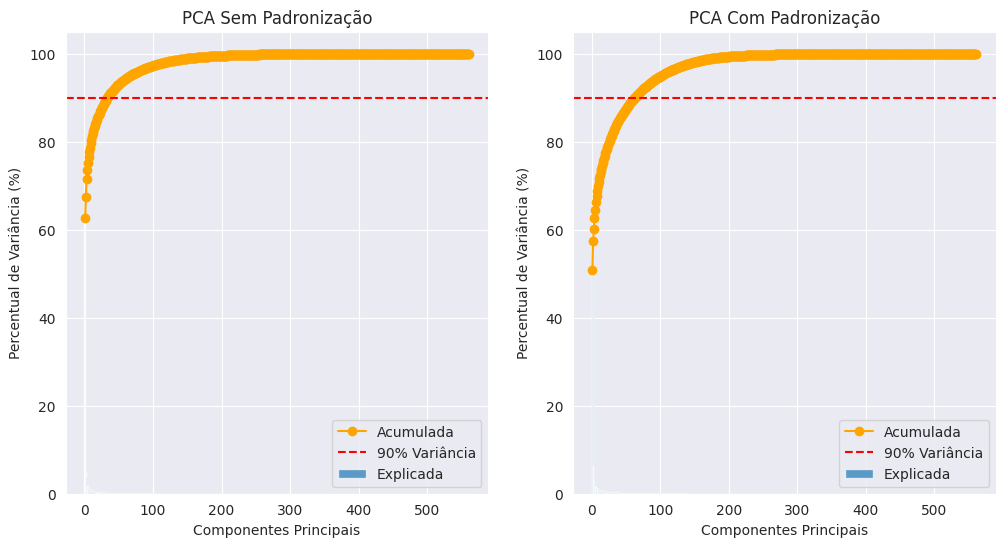

In [34]:
# Visualizacao dos resultados
plt.figure(figsize=(12, 6))

# Sem padronização
plt.subplot(1, 2, 1)
plt.bar(range(1, len(percent_variance_no_scaling) + 1), percent_variance_no_scaling, alpha=0.7, label='Explicada')
plt.plot(range(1, len(cumulative_variance_no_scaling) + 1), cumulative_variance_no_scaling * 100,
         marker='o', color='orange', label='Acumulada')
plt.axhline(90, color='red', linestyle='--', label='90% Variância')
plt.title('PCA Sem Padronização')
plt.xlabel('Componentes Principais')
plt.ylabel('Percentual de Variância (%)')
plt.legend()

# Com padronização
plt.subplot(1, 2, 2)
plt.bar(range(1, len(percent_variance_scaling) + 1), percent_variance_scaling, alpha=0.7, label='Explicada')
plt.plot(range(1, len(cumulative_variance_scaling) + 1), cumulative_variance_scaling * 100,
         marker='o', color='orange', label='Acumulada')
plt.axhline(90, color='red', linestyle='--', label='90% Variância')
plt.title('PCA Com Padronização')
plt.xlabel('Componentes Principais')
plt.ylabel('Percentual de Variância (%)')
plt.legend()


In [36]:
print("Sem padronização:")
print(f"Variância explicada por componente (%): {percent_variance_no_scaling}")
print(f"Variância explicada acumulada (%): {cumulative_variance_no_scaling * 100}")
print(f"Número de componentes para explicar 90% da variância: {components_to_90_no_scaling}\n")

print("Com padronização:")
print(f"Variância explicada por componente (%): {percent_variance_scaling}")
print(f"Variância explicada acumulada (%): {cumulative_variance_scaling * 100}")
print(f"Número de componentes para explicar 90% da variância: {components_to_90_scaling}")

Sem padronização:
Variância explicada por componente (%): [6.25544400e+01 4.91302272e+00 4.12146745e+00 1.87495612e+00
 1.69485999e+00 1.27206929e+00 1.17668514e+00 1.06897316e+00
 9.69379779e-01 8.58018171e-01 7.62301911e-01 6.72445661e-01
 5.79419596e-01 5.57880638e-01 4.98925730e-01 4.74937626e-01
 4.67200109e-01 4.31617860e-01 4.25715180e-01 4.10395039e-01
 3.94002401e-01 3.75309316e-01 3.52427488e-01 3.39359425e-01
 3.32138998e-01 3.19428786e-01 3.01779149e-01 2.91782575e-01
 2.89569956e-01 2.81927795e-01 2.76704148e-01 2.63395052e-01
 2.55306687e-01 2.35865883e-01 2.30652304e-01 2.23648168e-01
 2.22948133e-01 2.10275984e-01 2.08392917e-01 2.04773752e-01
 1.92856457e-01 1.88879623e-01 1.81180259e-01 1.79472696e-01
 1.72327672e-01 1.60201939e-01 1.57039496e-01 1.56627367e-01
 1.52969849e-01 1.50351278e-01 1.45117716e-01 1.40640152e-01
 1.36825069e-01 1.26857902e-01 1.25006115e-01 1.19742181e-01
 1.18119807e-01 1.14994893e-01 1.13082490e-01 1.09669551e-01
 1.07704072e-01 1.04900274e

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [38]:
%%time

percent_variance_no_scaling = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(X_train_pad, y_train).feature_importances_
caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(X_train_pad, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

percents_variance_no_scaling = []
for ccp_alpha in ccp_alphas:
    percent_variance_no_scaling = DecisionTreeClassifier(random_state=1234, ccp_alpha=ccp_alpha).fit(X_train_pad, y_train).feature_importances_
    percents_variance_no_scaling.append(percent_variance_no_scaling)

CPU times: user 3min 54s, sys: 3.53 ms, total: 3min 54s
Wall time: 3min 54s


In [46]:
print(percents_variance_no_scaling)

[array([0.00000000e+00, 3.92945107e-04, 0.00000000e+00, 0.00000000e+00,
       2.05204667e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.06446150e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08837163e-04,
       0.00000000e+00, 2.18302837e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.90812192e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.78772685e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.16397062e-03, 5.95739017e-03, 0.00000000e+00,
       2.39944712e-01, 2.46826121e-03, 5.58671245e-03, 1.58273360e-03,
     